# Energy Consumption Prediction

In this project, a deep learning model will be developed to predict the amount of energy consumed by a building with solar panel.

<table>
<tr>
<th>Column Name</th>
<th>Description</th>
</tr>
<tr>
<td>Month</td>
<td>The month of the year when the data was recorded.</td>
</tr>
<tr>
<td>Hour</td>
<td>The hour of the day when the data was recorded.</td>
</tr>
<tr>
<td>DayOfWeek</td>
<td>The day of the week when the data was recorded.</td>
</tr>
<tr>
<td>Holiday</td>
<td>Indicates whether the day was a holiday (Yes/No).</td>
</tr>
<tr>
<td>Temperature</td>
<td>The average daily temperature in Celsius.</td>
</tr>
<tr>
<td>Humidity</td>
<td>The average daily humidity level (%).</td>
</tr>
<tr>
<td>SquareFootage</td>
<td>The area of the building being monitored in m<sup>2</sup>.</td>
</tr>
<tr>
<td>Occupancy</td>
<td>The total number of people occupying the building.</td>
</tr>
<tr>
<td>HVACUsage</td>
<td>Indicates whether the HVAC system was in use (On/Off).</td>
</tr>
<tr>
<td>LightingUsage</td>
<td>Indicates whether the lighting system was in use (On/Off).</td>
</tr>
<tr>
<td>RenewableEnergy</td>
<td>The amount of renewable energy generated at the time of data collection.</td>
</tr>
<tr>
<td>EnergyConsumption (the goal)</td>
<td>The amount of energy consumed at the time of data collection.</td>
</tr>
</table>

## Importing the Needed Libraries

In [1]:
#For google colab uncomment this part of the code since we need to install some librares

# !pip install pyarrow #this is for reading parquet files

In [2]:
# Basic python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Data prepreocessing Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder

## Import the Data

In [3]:
data = pd.read_parquet("dataset_1A.parquet")
data.head()

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption
0,8,3,Sunday,Yes,24.492063,59.969085,1403.454805,7,On,Off,29.965327,82.05735763545306
1,1,8,Wednesday,No,26.312114,51.408711,1220.547133,8,On,Off,5.986875,83.88917674427188
2,1,19,Sunday,Yes,20.516186,40.918500,1114.230124,8,Off,On,20.489098,66.20209750906106
3,7,3,Wednesday,Yes,20.879426,46.859237,1096.207227,7,Off,On,21.321157,66.43917871187017
4,10,17,Saturday,No,23.015216,48.998158,1999.982252,1,Off,Off,3.966075,76.90227179904673


## EDA

### Check the Missing Values and Duplicates

#### The Number of Missing Values

In [4]:
missing_data_count = pd.DataFrame(data.isna().sum())
missing_data_count.columns = ["Number_Of_Data_Missing"]
missing_data_count["Percentage"] = round(missing_data_count["Number_Of_Data_Missing"]/len(data) * 100, 2)
missing_data_count

,Number_Of_Data_Missing,Percentage
Month,0,0.0
Hour,0,0.0
DayOfWeek,0,0.0
Holiday,0,0.0
Temperature,0,0.0
Humidity,0,0.0
SquareFootage,0,0.0
Occupancy,0,0.0
HVACUsage,0,0.0
LightingUsage,0,0.0


#### Check for Duplicates

In [5]:
print(data.duplicated().sum())

0


### Check the Data Types

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              1232 non-null   object 
 1   Hour               1232 non-null   int64  
 2   DayOfWeek          1232 non-null   object 
 3   Holiday            1232 non-null   object 
 4   Temperature        1232 non-null   float64
 5   Humidity           1232 non-null   float64
 6   SquareFootage      1232 non-null   float64
 7   Occupancy          1232 non-null   int64  
 8   HVACUsage          1232 non-null   object 
 9   LightingUsage      1232 non-null   object 
 10  RenewableEnergy    1232 non-null   float64
 11  EnergyConsumption  1232 non-null   object 
dtypes: float64(4), int64(2), object(6)
memory usage: 115.6+ KB


The data is roughly clean so far with some correct data types and no missing values. However the "EnergyConsumption" column has a wrong data type where it should be float64. Therefore, we will change that data type.

In [7]:
# Changing the data type of "EnergyConsumption"
data["EnergyConsumption"] = data["EnergyConsumption"].astype("float64")

In [8]:
# Recheck the data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              1232 non-null   object 
 1   Hour               1232 non-null   int64  
 2   DayOfWeek          1232 non-null   object 
 3   Holiday            1232 non-null   object 
 4   Temperature        1232 non-null   float64
 5   Humidity           1232 non-null   float64
 6   SquareFootage      1232 non-null   float64
 7   Occupancy          1232 non-null   int64  
 8   HVACUsage          1232 non-null   object 
 9   LightingUsage      1232 non-null   object 
 10  RenewableEnergy    1232 non-null   float64
 11  EnergyConsumption  1229 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 115.6+ KB


### Check the Range of the "Hours" Column

Let's check the "Hours" to get the range of the time is it a 12 hour format or a 24 hour format

In [9]:
min(data["Hour"]), max(data["Hour"]) 

(0, 23)

Looks like the data is in a 24 hour format so lets change it to a time format of HH:MM

### Plotting Data Distribution

#### Functions for plotting the distribution

In [10]:
#setting the colors generator
def fill_color_generator():
    """This generates a color

    Returns:
        color: An R,G,B value with a range of 0 to 1
    """
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

In [11]:
#function for plotting numerical data distribution
def numeric_dist_plot(data: pd.DataFrame):
    """This function creates a plot of the distribution of the numerical data. 

    Args:
        data (pd.DataFrame): Numeric pandas dataframe

    Raises:
        TypeError: The following columns are not numeric: {non_numeric_cols}
        This is due to some of the columns are not numeric.

    Returns:
        Displays a plot of
    """
    # Checks
    ## Check if all columns are numeric
    non_numeric_cols = [col for col in data.columns if not pd.api.types.is_numeric_dtype(data[col])]
    if non_numeric_cols:
        raise TypeError(f"The following columns are not numeric: {non_numeric_cols}")
    
    # Plotting the numerical data
    #titles for plots/figures
    fig_titles = []

    for colName in data.columns:
        fig_titles.append(f"Boxplot Of {colName}")
        fig_titles.append(f"Histogram Of {colName}")
        
    fill_color_dict = {}
    for colName in data.columns:
        fill_color_dict[colName] = fill_color_generator()

    # make subplot for each column name
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 3))

    # Flatten axes for easier indexing when there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    for i, column in enumerate(data.columns):
        color = fill_color_dict[column]

        # Boxplot
        axes[i][0].boxplot(data[column].dropna(), vert=False, patch_artist=True,
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color="black"))
        axes[i][0].set_title(f"Boxplot of {column}")
        axes[i][0].set_xlabel(column)

        # Histogram
        axes[i][1].hist(data[column].dropna(), bins=20, color=color, alpha=0.7, edgecolor='black')
        axes[i][1].set_title(f"Histogram of {column}")
        axes[i][1].set_xlabel(column)

    # Overall layout
    fig.suptitle("Boxplot and Distribution Visualization for Each Numeric Column", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
    return plt

In [12]:
#function for plotting categorical data distribution
def categoric_dist_plot(data: pd.DataFrame):
    """_summary_

    Args:
        data (pd.DataFrame): Categorical pandas dataframe

    Raises:
        TypeError: The following columns are not categorical: {non_numeric_cols}
        This is due to some of the columns are not categorical.

    Returns:
        plt: Plot of the categorical data distribution
    """
    # Checks
    ## Check if all columns are numeric
    non_categoric_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]
    if non_categoric_cols:
        raise TypeError(f"The following columns are not categoric: {non_categoric_cols}")

    # Create subplots: one row for each categorical column
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(10, num_rows * 3), sharex=False)

    # Flatten axes for easier handling if there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    # Plot each categorical distribution
    for i, col in enumerate(data.columns):
        counts = data[col].value_counts(dropna=False)  # Get the count values
        counts.index = counts.index.astype(str) #convert the categorical values to strings since there are numerical categories
        
        #Create the bar plot
        axes[i].bar(counts.index, counts)
        
        # Set title and labels
        axes[i].set_title(f"", fontsize=12)
        axes[i].set_ylabel("Count")
        axes[i].set_xlabel("Category")
        
        # Rotate x-axis labels for better readability
        axes[i].tick_params(axis='x', rotation=90)

    # Add an overall title and adjust layout
    fig.suptitle("Bar Plots for Categorical Columns", fontsize=16, y=1.02)
    fig.tight_layout(h_pad=2.0)  # Adjust spacing between rows
    return plt

#### Splitting Data to Categorical and Numeric

In [13]:
numeric_data = data.select_dtypes(include=[np.number])
categorical_data = data.select_dtypes(exclude=[np.number])

#### Numerical Data Plot

In [14]:
numeric_data.head()

,Hour,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption
0,3,24.492063,59.969085,1403.454805,7,29.965327,82.057358
1,8,26.312114,51.408711,1220.547133,8,5.986875,83.889177
2,19,20.516186,40.918500,1114.230124,8,20.489098,66.202098
3,3,20.879426,46.859237,1096.207227,7,21.321157,66.439179
4,17,23.015216,48.998158,1999.982252,1,3.966075,76.902272


<module 'matplotlib.pyplot' from 'c:\\Users\\Panther\\anaconda3\\envs\\pytorch_env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

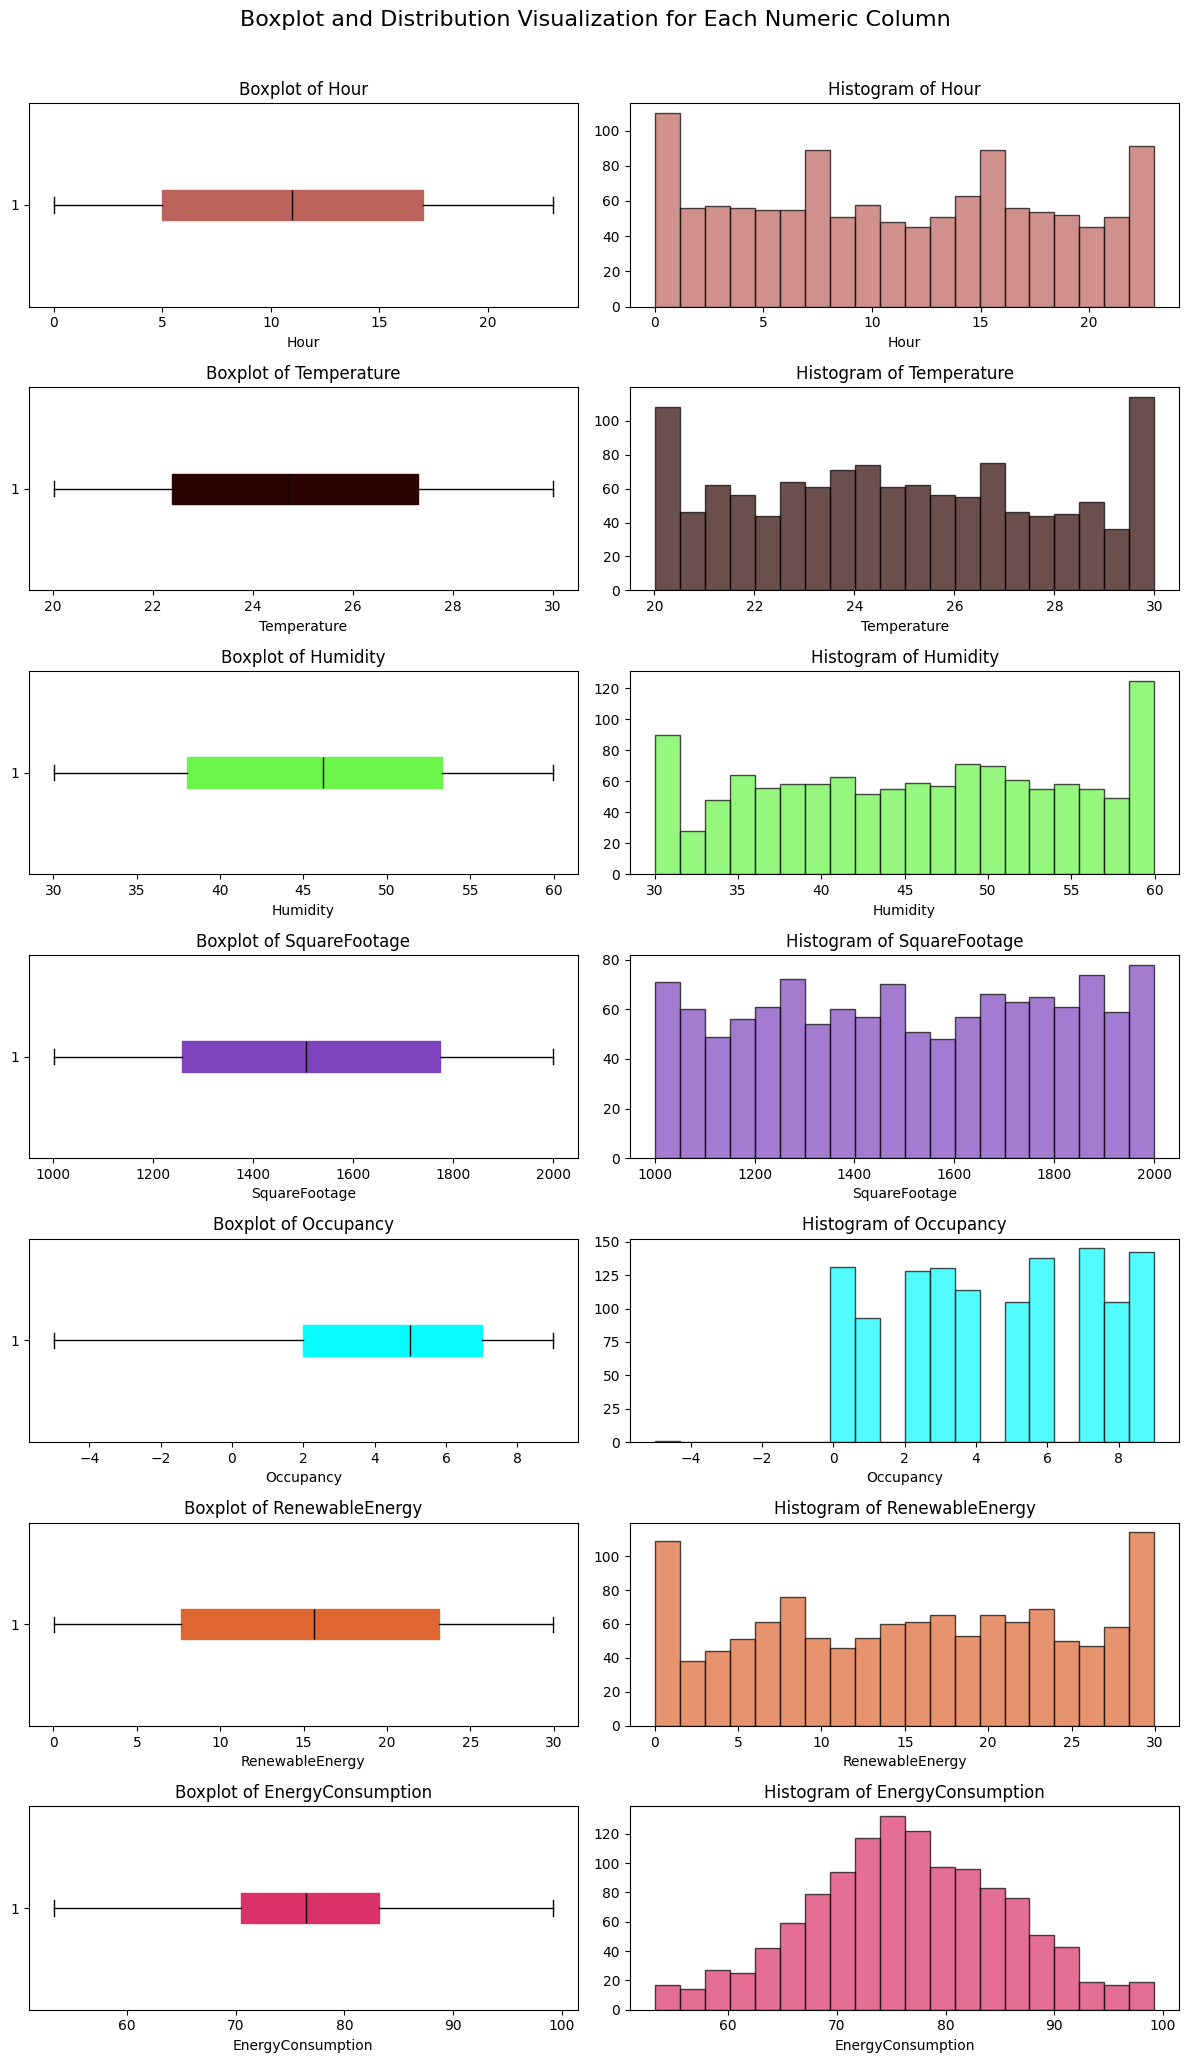

In [15]:
numeric_dist_plot(numeric_data)

#### Categorical Data Plot

In [16]:
categorical_data.head()

,Month,DayOfWeek,Holiday,HVACUsage,LightingUsage
0,8,Sunday,Yes,On,Off
1,1,Wednesday,No,On,Off
2,1,Sunday,Yes,Off,On
3,7,Wednesday,Yes,Off,On
4,10,Saturday,No,Off,Off


<module 'matplotlib.pyplot' from 'c:\\Users\\Panther\\anaconda3\\envs\\pytorch_env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

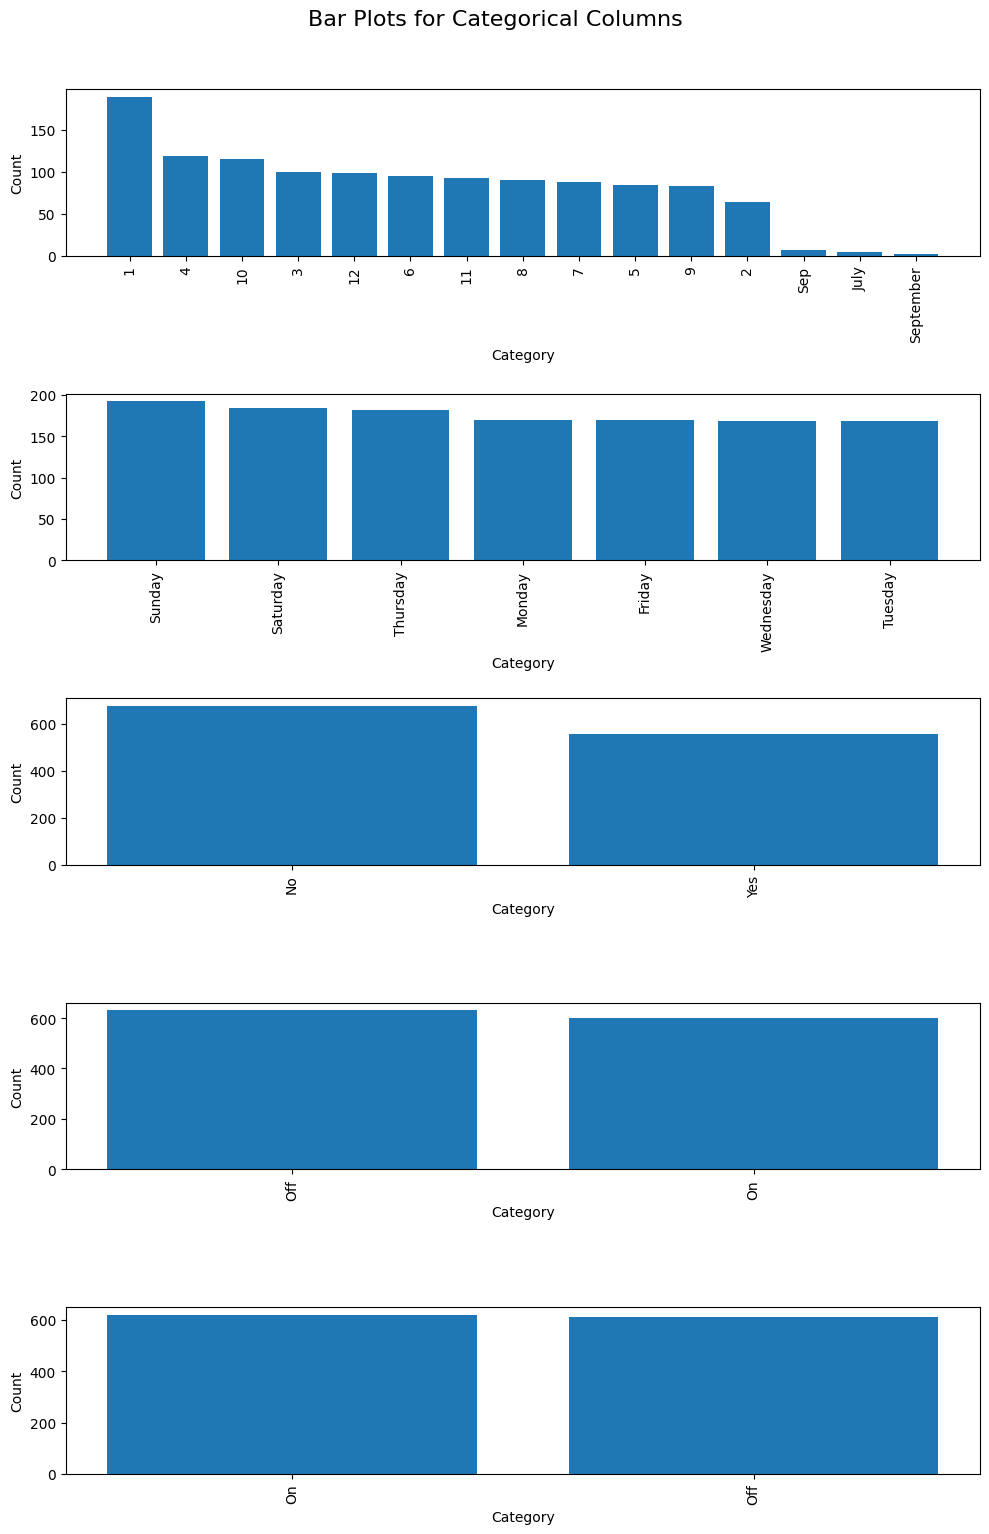

In [17]:
categoric_dist_plot(categorical_data)

### Key Insights
#### Problems With the Data
1. **Inconcistent Data Values**:
   - The months in the data is inconsistent. There are 3 types of month in the data (e.g. Numerical, partial month name, and full month name)
2. **Wierd Data Range**:
   - There seems to be a negative number of Occupancy as seen in the graph, and that is a outlier since there is nothing such as a negative number of people.
3. **Skewness**:
   - There are some skewness in the month data where there are mostly data from january.
   - The rest of the data are mostly uniform except for EnergyConsumption where it has a normal distribution.

#### Small Fixes
4. **Data Types**:
- Changing the data type of "EnergyConsumption" from `object` to `float64`

#### Next Steps


## Data Cleaning

- Standardizing the "month" data
- Cleaning the negative number of occupancy

### Next Steps
After cleaning the data from missing values by filling it with `0`, we can continue to prepreocess the data and prepare it for training.

At this point:
- The dataset is now clean and ready for further preprocessing or modeling.
- The handling of missing values and standardization of date formats ensures consistency.
- The presence of outliers in numerical data may require additional steps, such as scaling or outlier removal.

## Data Propressing

### Spitting data to train, test, and validation

#### Split data to the predictor and outcome

In [18]:
x_data = data.drop(columns=["EnergyConsumption"])
y_data = data["EnergyConsumption"]

In [19]:
# Check the columns
x_data.columns

Index(['Month', 'Hour', 'DayOfWeek', 'Holiday', 'Temperature', 'Humidity',
       'SquareFootage', 'Occupancy', 'HVACUsage', 'LightingUsage',
       'RenewableEnergy'],
      dtype='object')

In [20]:
y_data.head()

0    82.057358
1    83.889177
2    66.202098
3    66.439179
4    76.902272
Name: EnergyConsumption, dtype: float64

####  Split to train and test

In [21]:
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((985, 11), (247, 11), (985,), (247,))

#### Split to train and validation

In [22]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((788, 11), (197, 11), (788,), (197,))

So after splitting the data we will obtain the following:
<table>
<tr>
<th>Data</th>
<th>Size</th>
</tr>
<tr>
<td>Train</td>
<td>765</td>
</tr>
<tr>
<td>Validation</td>
<td>192</td>
</tr>
<tr>
<td>Test</td>
<td>240</td>
</tr>

### Scaling the Data

# E

<img src="haybale-rolling.gif">

bla bla bla <br>
bli bli bli <br>
blu blu blu <br>
hop <br>
blu blu blu blu blu blu <br>
blu blu blu blu blu blu <br>
blu blu blu blu blu blu <br>
blu blu blu blu blu blu <br>
blu blu blup<br>
ling gang guli guli guli wata <br>
wata ling gang gu <br>
ling gang gu <br>
ling gang guli guli guli wata <br>
wata ling gang gu <br>
ling gang gu <br>
ling gang guli guli guli wata <br>
wata ling gang gu <br>
ling gang gu